# V1.9
## Szenario-basierte Berechnungen für Energieverbrauchs- und Erzeugungsentwicklung bis 2030

In diesem Notebook führen wir Szenario-basierte Berechnungen für die Entwicklung von Energieverbrauch und -produktion durch.

## Importieren der Bibliotheken

Wir beginnen mit dem Importieren der erforderlichen Bibliotheken, einschließlich `pandas` für die Datenverarbeitung und `matplotlib` für die Visualisierung.

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
from pathlib import Path
from datetime import datetime

### selbstgeschriebene Utils
Für bessere Übersicht wurden Funktionen in Python-Skripte ausgelagert und werden hier importiert, damit sie später im Code aufgerufen werden können.

In [56]:
# eigene Utils
from utils.addTimeInformation import addTimeInformation
from utils.combineDataFrames import combineDataFrames
from utils.extraploation_class import Extrapolation
from utils.plotCalendarHeatmap import plotCalendarHeatmap
from utils.read_CSV import *
from utils.calcDifference_storage_flexpowerplant import differenceBetweenDataframes
from utils.calculateConsumption import calculateConsumption, getConsumptionYear, calculateConsumption_lastprofile
from utils.plotResidualDiagram import plotResidualDiagram
from utils.plotWeekDiagram import plotWeekDiagramm, create_week_comparison
from utils.determinePerformanceSzenarios import determinePerformanceSzenarios
from utils.performance_factors import performance_factors
from utils.addTimePerformance import addTimePerformance
from utils.dunkelflautePerformanceFactor import dunkelflautePerformanceFactor
from utils.load_profile_heat_pump import load_profile_heatpump
from utils.calculateGeneration import calculateGeneration
from datetime import datetime, timedelta

## Szenarien-Definition
Das Programm rechnet mit Variablen für `Verbrauchsentwicklung`, `PV-Leistung`, `Wind-Leistung (Onshore)` und `Windleistung (Onshore)`

Zu Beginn wird festgelegt, welches Szenario gerechnet werden soll, je nachdem werden die eben genannten Variablen festgesetzt. Die Werte für die Szenarien wurden aus den Big5-Studien ermittelt.

In [57]:
# Faktoren, Variablen

#consumption_development_rate = 1.045
consumption_development_per_year = {
    2024: 1.045,
    2025: 1.03,
    2026: 1.0335,
    2027: 1.066,
    2028: 0.89,
    2029: 1.09,
    2030: 1.02
}
onshore_development_rate = 1.129
offshore_development_rate = 1.066
pv_development_rate = 1.131
CO2_factor_Kohle = 0.35
CO2_factor_Gas = 0.2
share_coal = (100/39*23)/100
share_gas = (100/39*16)/100
IST_installierte_waermepumpen = 1400000
SOLL_installierte_waermepumpen = 5999000

## CSV einlesen (Erzeugung)
Wir lesen die SMARD-Daten für realisierte Erzeugung (2015-2023).
Ist das abgeschlossen, werden die Daten ab 2024 bis 2030 extrapoliert und in einem Dataframe gespeichert, dass Daten für alle Jahre enthält.

In [58]:
#alle Daten ab 2015 einlesen
directory_yearly_generation = getData("Generation")







Data für 2015 loaded succsessfully.
Data für 2016 loaded succsessfully.
Data für 2017 loaded succsessfully.
Data für 2018 loaded succsessfully.
Data für 2019 loaded succsessfully.
Data für 2020 loaded succsessfully.
Data für 2021 loaded succsessfully.
Data für 2022 loaded succsessfully.
Data für 2023 loaded succsessfully.


## PerformanceFaktoren(2015-2023):

Erstellung von Performance Faktoren um Wetterabhängigkeit zu implementiern und erzeugte Energie anhand der Installierten Leistung abzuleiten


In [59]:

directory_yearly_installed = getData("Installed")
directory_yearly_performance = performance_factors(directory_yearly_generation, directory_yearly_installed)
directory_szenarios=determinePerformanceSzenarios(directory_yearly_performance)
directory_szenarios["WorstCase"].to_csv("WorstCase.csv")
directory_szenarios["BestCase"]= addTimePerformance(directory_szenarios["BestCase"], 2030)
dunkelflautePerformanceFactor(directory_yearly_performance)


Data für 2015 loaded succsessfully.
Data für 2016 loaded succsessfully.
Data für 2017 loaded succsessfully.
Data für 2018 loaded succsessfully.
Data für 2019 loaded succsessfully.
Data für 2020 loaded succsessfully.
Data für 2021 loaded succsessfully.
Data für 2022 loaded succsessfully.
Data für 2023 loaded succsessfully.


/Users/private/Desktop/Projects/Klimaneutral-20245/utils/determinePerformanceSzenarios.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  meanPerformanceFactors = pd.concat([meanPerformanceFactors, pd.DataFrame([{"Jahr": year, "Photovoltaik": meanPV, "Wind Onshore": meanOnshore, "Wind Offshore": meanOffshore}])], ignore_index=True)


Es lag eine Dunkelflaute vom 2015-01-18 14:45:00 bis zum 2015-01-21 14:30:00 vor Anzahl Viertelstunden: 288
Es lag eine Dunkelflaute vom 2021-01-06 23:45:00 bis zum 2021-01-09 23:30:00 vor Anzahl Viertelstunden: 288
Es lag eine Dunkelflaute vom 2022-11-29 01:30:00 bis zum 2022-12-02 01:15:00 vor Anzahl Viertelstunden: 288


In [60]:
def calculateGeneration(case_PV, case_WindOnshore, case_WindOffshore, df_performance, df_generation_start_year):
    """
    Calculate energy generation based on installed capacity projections and performance data.

    Args:
        case_PV (str): Case identifier for Photovoltaik.
        case_WindOnshore (str): Case identifier for Wind Onshore.
        case_WindOffshore (str): Case identifier for Wind Offshore.
        df_performance (pd.DataFrame): Performance factors for each technology.
        df_generation_start_year (pd.DataFrame): Baseline generation data for other sources.

    Returns:
        dict: Directory of yearly generation data.
    """

    directoryGeneration = {}
    directoryInstalled = {}

    # Paths to CSV files
    filepath_PV = f'CSV/Installed/{case_PV}_Photovoltaik_projections.csv'
    filepath_Onshore = f'CSV/Installed/{case_WindOnshore}_Wind Onshore_projections.csv'
    filepath_Offshore = f'CSV/Installed/{case_WindOffshore}_Wind Offshore_projections.csv'

    # Ensure files exist
    for filepath in [filepath_PV, filepath_Onshore, filepath_Offshore]:
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"File not found: {filepath}")

    # Load and filter CSV files
    df_PV = pd.read_csv(filepath_PV)
    df_Onshore = pd.read_csv(filepath_Onshore)
    df_Offshore = pd.read_csv(filepath_Offshore)

    df_filtered_PV = df_PV[df_PV['year'] >= 2024].reset_index(drop=True)
    df_filtered_Onshore = df_Onshore[df_Onshore['year'] >= 2024].reset_index(drop=True)
    df_filtered_Offshore = df_Offshore[df_Offshore['year'] >= 2024].reset_index(drop=True)

    # Combine filtered data
    df_combined = pd.concat([
        df_filtered_PV[['year', 'predicted_capacity']],
        df_filtered_Onshore['predicted_capacity'],
        df_filtered_Offshore['predicted_capacity']
    ], axis=1)

    df_combined.columns = ['Year', 'Photovoltaik', 'Wind Onshore', 'Wind Offshore']

    # Populate directoryInstalled
    for _, row in df_combined.iterrows():
        directoryInstalled[row['Year']] = {
            'Photovoltaik': row['Photovoltaik'],
            'Wind Onshore': row['Wind Onshore'],
            'Wind Offshore': row['Wind Offshore']
        }

    # Calculate generation for each year
    for year in range(2024, 2031):
        num_days = 365

        if directoryInstalled.get(year + 1):
            next_year_data = directoryInstalled[year + 1]
            current_year_data = directoryInstalled[year]

            daily_expansion_rate = {
                tech: (next_year_data[tech] - current_year_data[tech]) / num_days
                for tech in ['Photovoltaik', 'Wind Onshore', 'Wind Offshore']
            }
        else:
            daily_expansion_rate = {tech: 0 for tech in ['Photovoltaik', 'Wind Onshore', 'Wind Offshore']}

        yearly_generation = pd.DataFrame(index=range(35040), columns=[
            'Datum', 'Photovoltaik', 'Wind Onshore', 'Wind Offshore',
            'Wasserkraft', 'Biomasse', 'Sonstige Erneuerbare'
        ])

        # Generate datetime values for "Datum" column
        start_date = datetime(year, 1, 1)
        datetime_range = [start_date + timedelta(minutes=15 * i) for i in range(35040)]
        yearly_generation['Datum'] = [dt.strftime("%Y-%m-%d  %H:%M") for dt in datetime_range]

        for day in range(num_days):
            start_index = day * 96
            end_index = start_index + 96

            daily_installed_capacity = {
                tech: directoryInstalled[year][tech] + daily_expansion_rate[tech] * day
                for tech in ['Photovoltaik', 'Wind Onshore', 'Wind Offshore']
            }

            for tech in ['Photovoltaik', 'Wind Onshore', 'Wind Offshore']:
                yearly_generation.loc[start_index:end_index - 1, tech] = (
                    daily_installed_capacity[tech] * 0.25 * df_performance[tech][start_index:end_index].values
                )

        for tech in ['Wasserkraft', 'Biomasse', 'Sonstige Erneuerbare']:
            yearly_generation[tech] = df_generation_start_year[tech] * 0.95279

        # Apply losses
        for tech in ['Photovoltaik', 'Wind Onshore', 'Wind Offshore']:
            yearly_generation[tech] *= 0.95279

        directoryGeneration[year] = yearly_generation


    return directoryGeneration

In [61]:
directory_yearly_generation.update(calculateGeneration("best_case", "best_case", "best_case", directory_szenarios["BestCase"], directory_yearly_generation[2023]))
directory_yearly_generation[2030].reset_index(drop=True, inplace=True)

directory_yearly_generation[2030].to_csv("2030.csv")

## Erzeugung 2030 (Gesamt)

Wir erstellen ein neues Dataframe nur für 2030, das nun zusätzlich auch die Gesamtsumme der EE-Erzeugung enthält (15-Min-AUflösung).

In [62]:
# Lade die Daten für das Jahr 2030
df_2030 = directory_yearly_generation[2024]


# Überprüfe, ob die Spalten vorhanden sind
required_columns = ['Wind Offshore', 'Wind Onshore', 'Photovoltaik']
if all(column in df_2030.columns for column in required_columns):
    # Berechne die Summe der gewünschten Spalten für jede 15-Minuten-Periode
    df_2030['Gesamterzeugung_EE'] = df_2030[required_columns].sum(axis=1)
    
    # Speichere die Ergebnisse in production_2030
    production_2030 = df_2030[['Datum', 'Gesamterzeugung_EE']]
    
    #print(production_2030)
else:
    print("Eine oder mehrere der erforderlichen Spalten fehlen im DataFrame für 2030.")

# Verbrauch 2030 (Gesamt)

Wir erstellen ein neues Dataframe nur für 2030, das nun zusätzlich auch den Gesamtverbrauch enthält (15-Min-AUflösung).

## Lastprofile Wärmepumpe 2023-2030

In [63]:
directory_heatpump_consumption = load_profile_heatpump(IST_installierte_waermepumpen,SOLL_installierte_waermepumpen,2024,2030)
print(directory_heatpump_consumption)

{2024:                     Datum   Verbrauch
0     2024-01-01 00:00:00  253.209169
1     2024-01-01 00:15:00  253.262739
2     2024-01-01 00:30:00  254.114389
3     2024-01-01 00:45:00  253.879472
4     2024-01-01 01:00:00  253.702878
...                   ...         ...
35035 2024-12-31 22:45:00  369.089405
35036 2024-12-31 23:00:00  364.579900
35037 2024-12-31 23:15:00  365.180400
35038 2024-12-31 23:30:00  364.288467
35039 2024-12-31 23:45:00  362.736274

[35040 rows x 2 columns], 2025:                     Datum   Verbrauch
0     2025-01-01 00:00:00  391.633553
1     2025-01-01 00:15:00  391.716408
2     2025-01-01 00:30:00  393.033638
3     2025-01-01 00:45:00  392.670297
4     2025-01-01 01:00:00  392.397162
...                   ...         ...
35035 2025-12-31 22:45:00  499.671925
35036 2025-12-31 23:00:00  493.566973
35037 2025-12-31 23:15:00  494.379928
35038 2025-12-31 23:30:00  493.172432
35039 2025-12-31 23:45:00  491.071078

[35040 rows x 2 columns], 2026:                

## Lastprofile eAutos

In [64]:
lastprofil_workday = pd.read_csv('CSV/Lastprofile/eMobilitaet/lastprofil_werktag.csv', delimiter= ';', thousands='.', decimal=',', dayfirst ="True") #, parse_dates=[[0,1]]
lastprofil_saturday = pd.read_csv('CSV/Lastprofile/eMobilitaet/lastprofil_samstag.csv', delimiter= ';', thousands='.', decimal=',', dayfirst ="True") #, parse_dates=[[0,1]]
lastprofil_sunday = pd.read_csv('CSV/Lastprofile/eMobilitaet/lastprofil_sonntag.csv', delimiter= ';', thousands='.', decimal=',', dayfirst ="True") #, parse_dates=[[0,1]]

# Speichern der Lastprofile in einem Dictionary
lastprofile_dict = {
    'workday': lastprofil_workday,
    'saturday': lastprofil_saturday,
    'sunday': lastprofil_sunday
}

# zu Hochrechnung übergeben wir die allgemeien Wachstumsrate pro Jahr, die Lastprofile EAutos und die Lastprofile für alle Jahre der Wärmepumpen
consumption_existing_years_lastprofile = calculateConsumption_lastprofile(consumption_development_per_year, lastprofile_dict, directory_heatpump_consumption)

Data für 2023 loaded succsessfully.


## Verbrauch an sich extrapolieren

In [65]:
consumption_existing_years = calculateConsumption(consumption_development_per_year)
consumption_2030 = consumption_existing_years.get(2030)

# print(consumption_2030)

Data für 2023 loaded succsessfully.


## Wochenvergleich zwischen Verbrauch und Verbrauch+Lastprofile

                    Datum  Gesamtverbrauch
17372 2030-07-01 00:00:00     12054.156430
17373 2030-07-01 00:15:00     11842.775866
17374 2030-07-01 00:30:00     11625.355856
17375 2030-07-01 00:45:00     11472.068998
17376 2030-07-01 01:00:00     11358.182327
...                   ...              ...
18039 2030-07-07 22:45:00     13317.263149
18040 2030-07-07 23:00:00     12977.041098
18041 2030-07-07 23:15:00     12781.478127
18042 2030-07-07 23:30:00     12580.738489
18043 2030-07-07 23:45:00     12398.979963

[672 rows x 2 columns]
                    Datum  Gesamtverbrauch
17372 2030-07-01 00:00:00     12866.535161
17373 2030-07-01 00:15:00     12591.117697
17374 2030-07-01 00:30:00     12309.660788
17375 2030-07-01 00:45:00     12092.337031
17376 2030-07-01 01:00:00     11914.413459
...                   ...              ...
18039 2030-07-07 22:45:00     14281.533101
18040 2030-07-07 23:00:00     13902.841349
18041 2030-07-07 23:15:00     13672.257000
18042 2030-07-07 23:30:00     

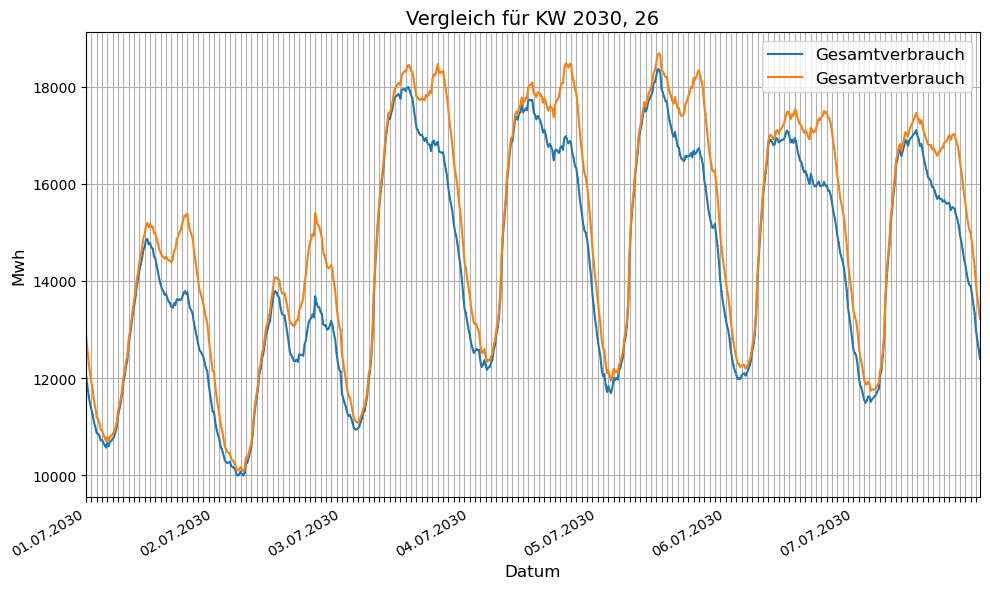

In [66]:
selected_week = '26'
selected_year = '2030'



def get_weekly_consumption(consumption_data, selected_year, selected_week):
    # Erstelle einen DataFrame aus dem Dictionary
    yearly_consumption = pd.DataFrame.from_dict(consumption_data.get(int(selected_year)))

    # Filtere die Daten für die angegebene Woche und das Jahr
    week_filtered_data_consumption = yearly_consumption[
        (yearly_consumption['Week'] == selected_week)
    ]

    # Erstelle einen DataFrame nur mit Datum und Gesamtverbrauch
    week_consumption_df = week_filtered_data_consumption[['Datum', 'Gesamtverbrauch']]
    week_consumption_df.loc[:, 'Datum'] = pd.to_datetime(week_consumption_df['Datum'])

    return week_consumption_df


# Verwende die Funktion für consumption_existing_years
week_consumption_df = get_weekly_consumption(consumption_existing_years, selected_year, selected_week)

# Verwende die Funktion für consumption_existing_years_lastprofile
week_consumption_df_lp = get_weekly_consumption(consumption_existing_years_lastprofile, selected_year, selected_week)

print(week_consumption_df)
print(week_consumption_df_lp)

# didirectory_yearly_generation and consumption_existing_years are dicitionaries

create_week_comparison(selected_week, selected_year, week_consumption_df, week_consumption_df_lp)

# Differenz bilden

Wir bestimmen die Resiudallast als Differenz zwischen Verbrauch und Erzeugung für die 2030-Dataframes.
Damit können wir den Anteil nicht-EE-Energie bestimmen an der Gesamtenergieerzeugung, der Anteil soll abnehmen.

In [87]:
# Annahme: consumption_2030 und production_2030 sind bereits definierte DataFrames mit einer 'Datum'-Spalte und einer 'Gesamtverbrauch'-Spalte
consumption_2030 = consumption_existing_years.get(2024)
# Konvertieren der 'Datum'-Spalte in ein Datetime-Format
consumption_2030['Datum'] = pd.to_datetime(consumption_2030['Datum'], format='%Y-%m-%d %H:%M')
production_2030['Datum'] = pd.to_datetime(production_2030['Datum'], format='%Y-%m-%d %H:%M')

# Entfernen des 29. Februars und des 31. Tages aus den DataFrames
consumption_2030 = consumption_2030[~((consumption_2030['Datum'].dt.month == 2) & (consumption_2030['Datum'].dt.day == 29))]
production_2030 = production_2030[~((production_2030['Datum'].dt.month == 2) & (production_2030['Datum'].dt.day == 29))]

consumption_2030 = consumption_2030[~((consumption_2030['Datum'].dt.month == 12) & (consumption_2030['Datum'].dt.day == 31))]
production_2030 = production_2030[~((production_2030['Datum'].dt.month == 12) & (production_2030['Datum'].dt.day == 31))]

print(consumption_2030[(consumption_2030['Datum'].dt.month == 12) & (consumption_2030['Datum'].dt.day == 31)])


# Konvertieren der 'Datum'-Spalte in das gewünschte Format
consumption_2030['Datum'] = consumption_2030['Datum'].dt.strftime('%Y-%m-%d %H:%M')
production_2030['Datum'] = production_2030['Datum'].dt.strftime('%Y-%m-%d %H:%M')

# Zurücksetzen des Indexes, um die Lücken zu schließen
consumption_2030.reset_index(drop=True, inplace=True)
production_2030.reset_index(drop=True, inplace=True)



combined_df = pd.DataFrame({
    'Datum': consumption_2030['Datum'],
    'Datum_2': production_2030['Datum']
})

differences = combined_df[combined_df['Datum'] != combined_df['Datum_2']]

# Ausgeben der Unterschiede
print("Unterschiede zwischen den Spalten 'Datum' und 'Datum_2':")
print(differences)

# Schreiben des neuen DataFrames in eine CSV-Datei
combined_df.to_csv("concat_2030.csv", sep=';', index=False)

print(len(consumption_2030['Datum']))
print(len(production_2030['Datum']))





resdidual_df = differenceBetweenDataframes(consumption_2030, production_2030)

print(resdidual_df)

Empty DataFrame
Columns: [Datum, Gesamtverbrauch, Year, Time, Month, Year Month, Year Month Day, Day, Weekday, Week]
Index: []
Unterschiede zwischen den Spalten 'Datum' und 'Datum_2':
                  Datum           Datum_2
8072   2024-03-26 03:00  2024-03-26 02:00
8073   2024-03-26 03:15  2024-03-26 02:15
8074   2024-03-26 03:30  2024-03-26 02:30
8075   2024-03-26 03:45  2024-03-26 02:45
8076   2024-03-26 04:00  2024-03-26 03:00
...                 ...               ...
28899  2024-10-29 01:45  2024-10-29 00:45
28900  2024-10-29 02:00  2024-10-29 01:00
28901  2024-10-29 02:15  2024-10-29 01:15
28902  2024-10-29 02:30  2024-10-29 01:30
28903  2024-10-29 02:45  2024-10-29 01:45

[20832 rows x 2 columns]
34944
34944
Die Zeitachsen der DataFrames stimmen nicht überein.
Unterschiede in df1['Datum']: 8072     2024-03-26 03:00
8073     2024-03-26 03:15
8074     2024-03-26 03:30
8075     2024-03-26 03:45
8076     2024-03-26 04:00
               ...       
28899    2024-10-29 01:45
28900    

# Auswertung
Um die Daten besser zu verstehen, plotten wir verschiedene Diagramme in unterschiedlicher Auflösung (15min - jährlich) für verschiedene Kennzahlen.
- Heatmap für ein Jahr
- Summenhistogramm für ein Jahr
- Residuallast über die Jahre bis 2030
- Wochendiagramm für den Vergleich von Verbrauch und Erzeugung

## HeatMap

Für das Jahr 2030 plotten wir eine Heatmap: Grüne Flächen bedeuten eine gute Abdeckung des Verbrauchs durch EE-Energie, rote Flächen zeigen Defizite in der EE-Versorgung.

In [68]:
plotCalendarHeatmap(resdidual_df, "Überschüssige/Restbedarf Energie", "Differenz", linewidths = 0)

AttributeError: 'NoneType' object has no attribute 'pivot_table'

## Summenhistogramm
Zusätzlich wird ein Summendiagramm erstellt, das die Anzahl der zu 80% durch EE-Energie gedeckten 15-Minuten aufzeigt.

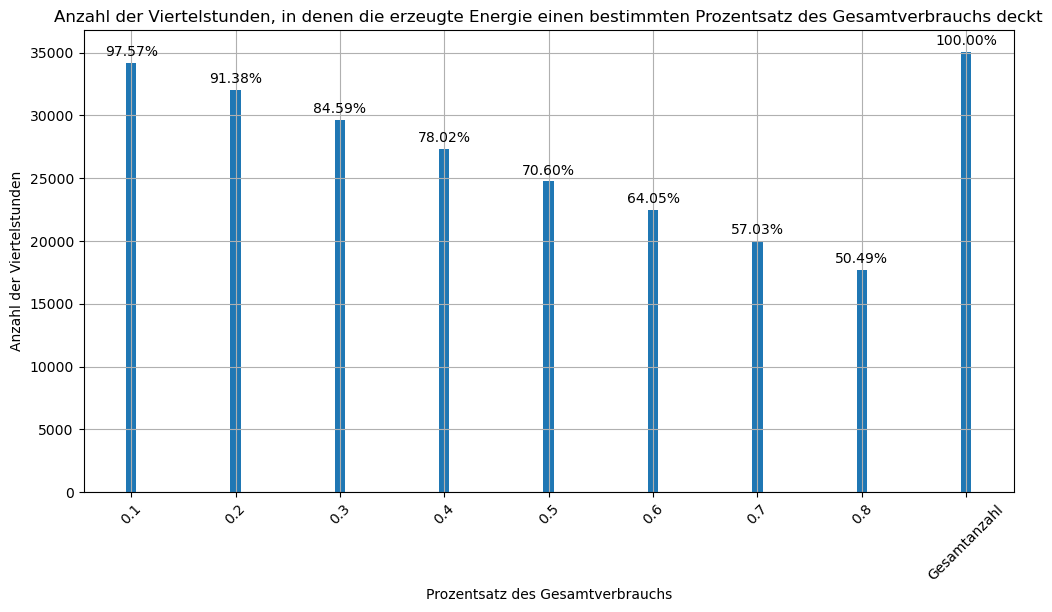

In [ ]:

# Prozentsätze definieren
percentages = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

# Dictionary, um die Anzahl der Viertelstunden für jeden Prozentsatz zu speichern
coverage_counts = {percentage: 0 for percentage in percentages}

# Berechne die Deckung für jede Viertelstunde
for index, row in production_2030.iterrows():
    for percentage in percentages:
        if row['Gesamterzeugung_EE'] >= percentage * consumption_2030.loc[index, 'Gesamtverbrauch']:
            coverage_counts[percentage] += 1

# Füge die Gesamtanzahl der Viertelstunden hinzu
total_quarters = len(production_2030)
coverage_counts['Gesamtanzahl'] = total_quarters

# Erstelle ein Summenhistogramm
plt.figure(figsize=(12, 6))
# Convert keys to strings for consistent data types
coverage_counts_str_keys = {str(key): value for key, value in coverage_counts.items()}

bars = plt.bar(coverage_counts_str_keys.keys(), coverage_counts_str_keys.values(), width=0.10, align='center')

# Annotate bars with percentage of total quarters
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_quarters) * 100
    plt.annotate(f'{percentage:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel('Prozentsatz des Gesamtverbrauchs')
plt.ylabel('Anzahl der Viertelstunden')
plt.title('Anzahl der Viertelstunden, in denen die erzeugte Energie einen bestimmten Prozentsatz des Gesamtverbrauchs deckt')
plt.xticks([str(key) for key in coverage_counts.keys()], rotation=45)
plt.grid(True)
plt.show()

## Diagramm für Residuallast (Differenz zw. EE-Erzeugung und Verbrauch)

**positive Differenz (Erzeugung > Verbrauch)**<br>
Hinweis auf eine Überschussproduktion, die EE-Erzeugung deckt den Verbrauch vollkommen und darüber hinaus. Der erzeugte Strom kann nicht vollständig verwendet werden (Exportmöglichkeit).

**negative Differenz (Erzeugung < Verbrauch)**<br>
Der Verbrauch ist höher als die EE-Erzeugung und kann also nicht abgedeckt werden. EE müssen ausgebaut werden.

**Trend**<br>
Die Differenz kann bei höherer Auflösung betrachtet evtl. schwanken -> saisonale Unterschiede in Produktionsmöglichkeiten für EE (bsp. im Winter weniger Sonne).
Ein positiver langfristiger Trend könnte auf eine erfolgreiche Integration erneuerbarer Energien hinweisen, während ein negativer langfristiger Trend auf Herausforderungen bei der Deckung des Energiebedarfs durch erneuerbare Energien hinweisen könnte.


In [ ]:
plotResidualDiagram(2023, 2030, directory_yearly_generation, consumption_existing_years)

## Wochendiagramm: Vergleich Verbrauch Erzeugung/Verbrauch, 15min

In [ ]:
selected_week = '02'
selected_year = '2030'



# didirectory_yearly_generation and consumption_existing_years are dicitionaries

plotWeekDiagramm(selected_week, selected_year, consumption_existing_years, directory_yearly_generation)

/Users/private/Desktop/Projects/Klimaneutral-20245/utils/plotWeekDiagram.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])
/Users/private/Desktop/Projects/Klimaneutral-20245/utils/addTimeInformation.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = df['Datum'].dt.time
/Users/private/Desktop/Projects/Klimaneutral-20245/utils/addTimeInformation.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

                   Datum  Gesamterzeugung_EE      Time Month Year Month  \
1248 2030-01-14 00:00:00        22893.568816  00:00:00   Jan    2030 01   
1249 2030-01-14 00:15:00        23074.466043  00:15:00   Jan    2030 01   
1250 2030-01-14 00:30:00        23089.838233  00:30:00   Jan    2030 01   
1251 2030-01-14 00:45:00        22852.290223  00:45:00   Jan    2030 01   
1252 2030-01-14 01:00:00        22478.889069  01:00:00   Jan    2030 01   
...                  ...                 ...       ...   ...        ...   
1915 2030-01-20 22:45:00         2273.900733  22:45:00   Jan    2030 01   
1916 2030-01-20 23:00:00         2362.232232  23:00:00   Jan    2030 01   
1917 2030-01-20 23:15:00         2441.291052  23:15:00   Jan    2030 01   
1918 2030-01-20 23:30:00         2524.839839  23:30:00   Jan    2030 01   
1919 2030-01-20 23:45:00         2619.943434  23:45:00   Jan    2030 01   

     Year Month Day Day  Year Weekday Week  
1248     2030 01 14  14  2030       1   02  
1249     

/Users/private/Desktop/Projects/Klimaneutral-20245/utils/addTimeInformation.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year Month Day'] = df['Datum'].dt.strftime('%Y %m %d')
/Users/private/Desktop/Projects/Klimaneutral-20245/utils/addTimeInformation.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day'] = df['Datum'].dt.strftime('%d')
/Users/private/Desktop/Projects/Klimaneutral-20245/utils/addTimeInformation.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

TypeError: 'NoneType' object is not subscriptable

# CO2-Bilanz bilden

Wir untersuchen weiterhin die Residuallast - die hier verbleibenden MWh geben uns Auskunft über die verbleibenden CO2-Emissionen. Ist die Resiudalllast = 0, sind auch die Emissionen auf 0T gesunken.
Die Emissionen werden pro fossielem Energieträger (Kohle und Gas) berechnet. Eine MWH hat je Energieträger produziert spezifische Werte CO2-Tonnen, diese werden aufsummiert.


In [ ]:
#Summiere die Differenz der Viertelstunden
total_residual_energy = (resdidual_df['Differenz'].sum())

print(f"Insgesamt müssen {total_residual_energy/1000} GWh über fossile Brennstoffe erzeugt werden.")

if total_residual_energy > 0:
    total_residual_energy_CO2_Kohle = total_residual_energy * CO2_factor_Kohle * share_coal
    total_residual_energy_CO2_gas = total_residual_energy * CO2_factor_Gas * share_gas 
    total_co2 = total_residual_energy_CO2_Kohle + total_residual_energy_CO2_gas
    print("Es werden insgesamt {} Tonnen CO2 emittiert. Davon sind {} Tonnen CO2 aus Kohle und {} Tonnen CO2 aus Gas.".format(total_co2, total_residual_energy_CO2_Kohle, total_residual_energy_CO2_gas))
elif total_residual_energy < 0:
    print("Es wird kein CO2 emittiert.")
else:
    print("Es liegt ein Fehler in der Berechnung vor.") 

TypeError: 'NoneType' object is not subscriptable

# User-Info